# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import string



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
print(df_reviews.head())
print(df_reviews.info())

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

I think that focusng on only on the review itself will be sufficient for this task, which is to classify the text review as either positive or negative. 

In [6]:
duplicates = df_reviews[['review', 'pos', 'ds_part']].duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 90


In [7]:
df_reviews.drop_duplicates(subset=['review', 'pos', 'ds_part'], keep='first', inplace=True)


I removed duplicates from the dataset, as it is highly unlikely that users wrote the exact same reviews with the exact same information in the row. The number or rows removed will likely not impact the training as it is minimal. 

## EDA

Let's check the number of movies and reviews over years.

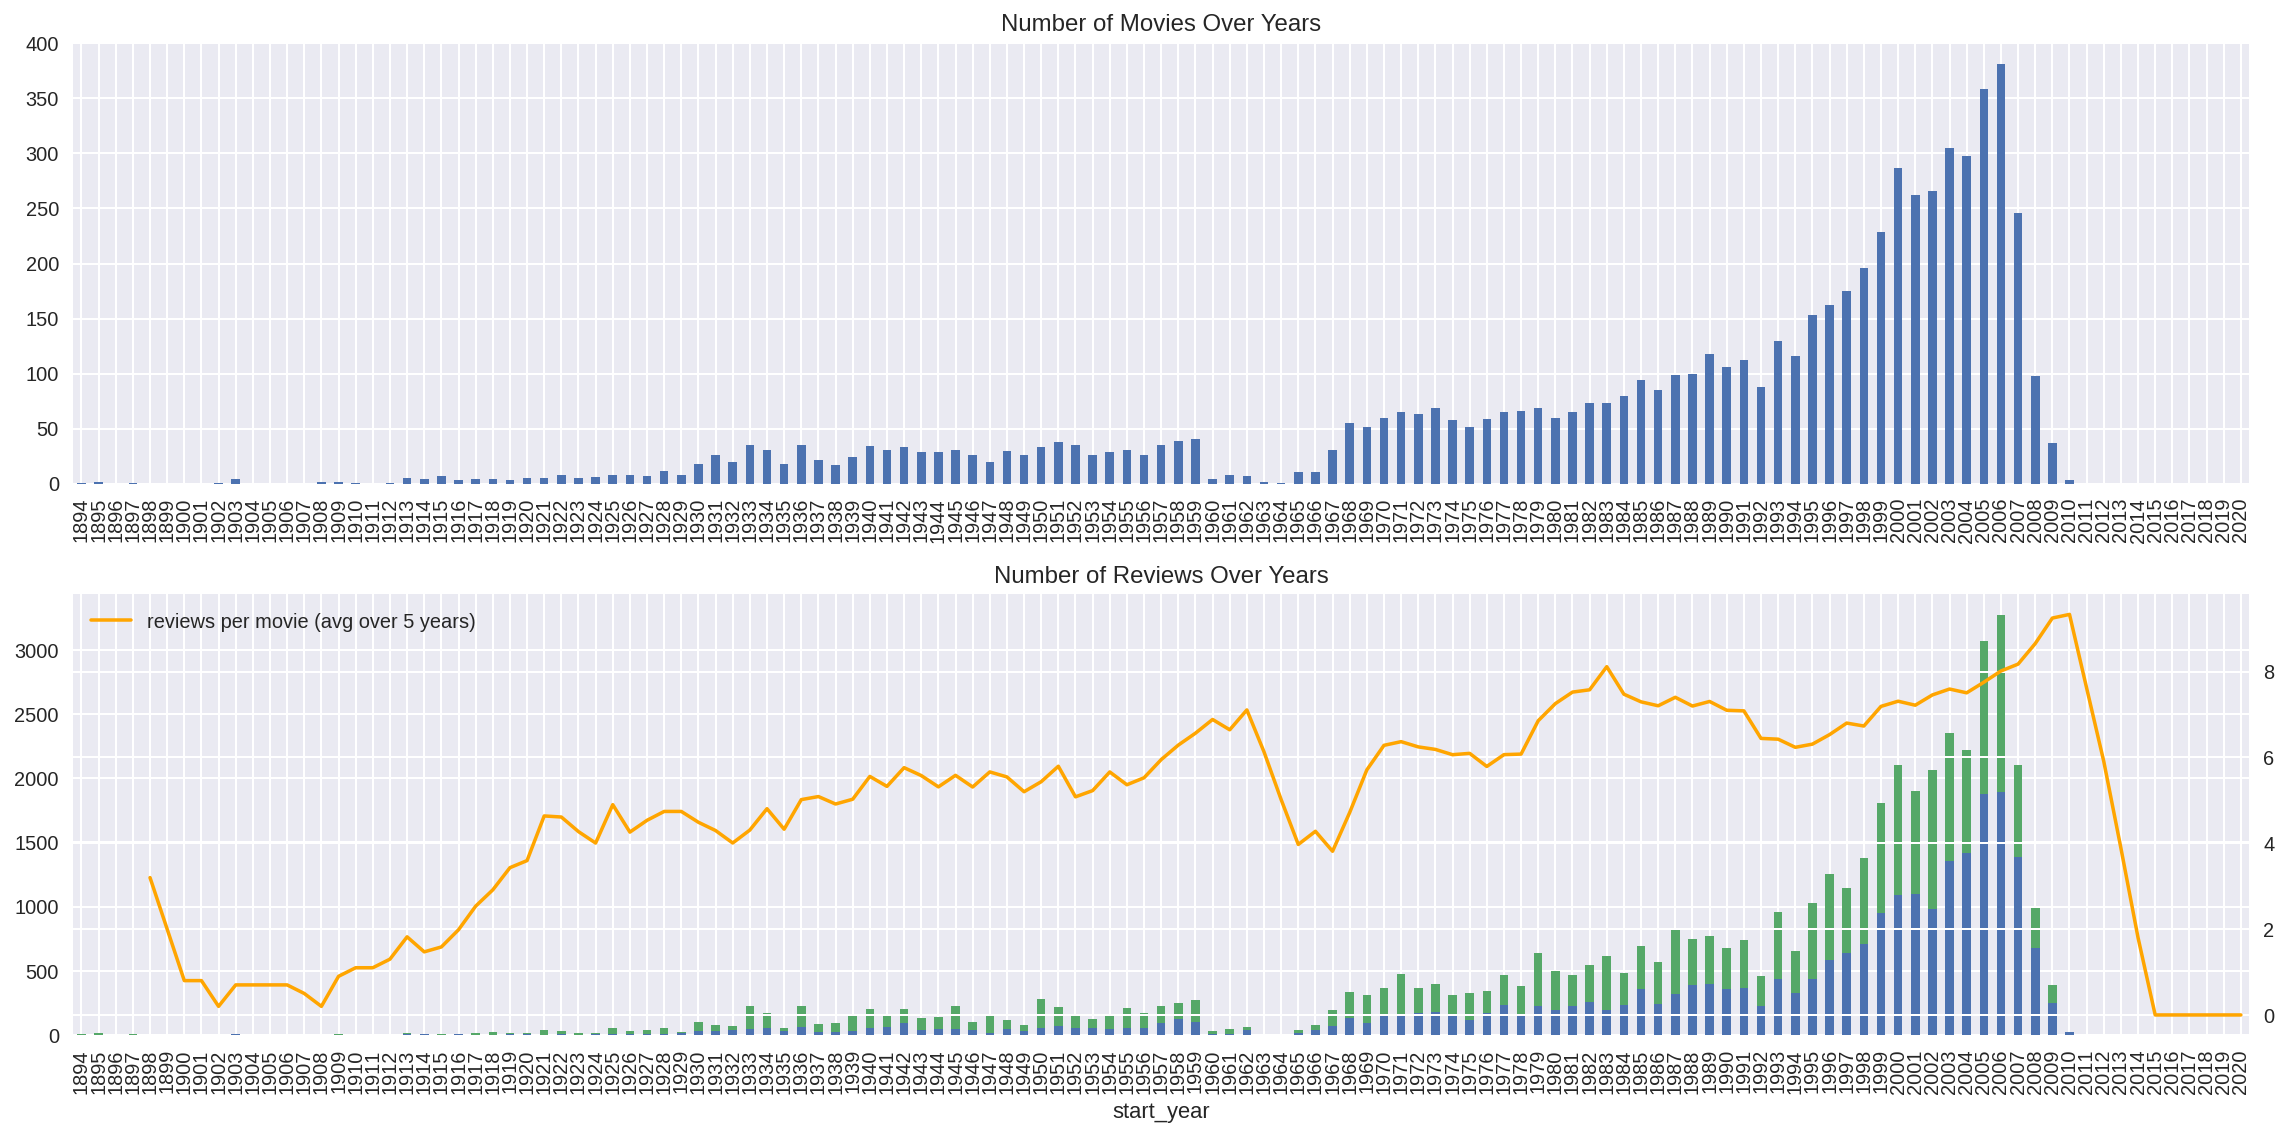

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

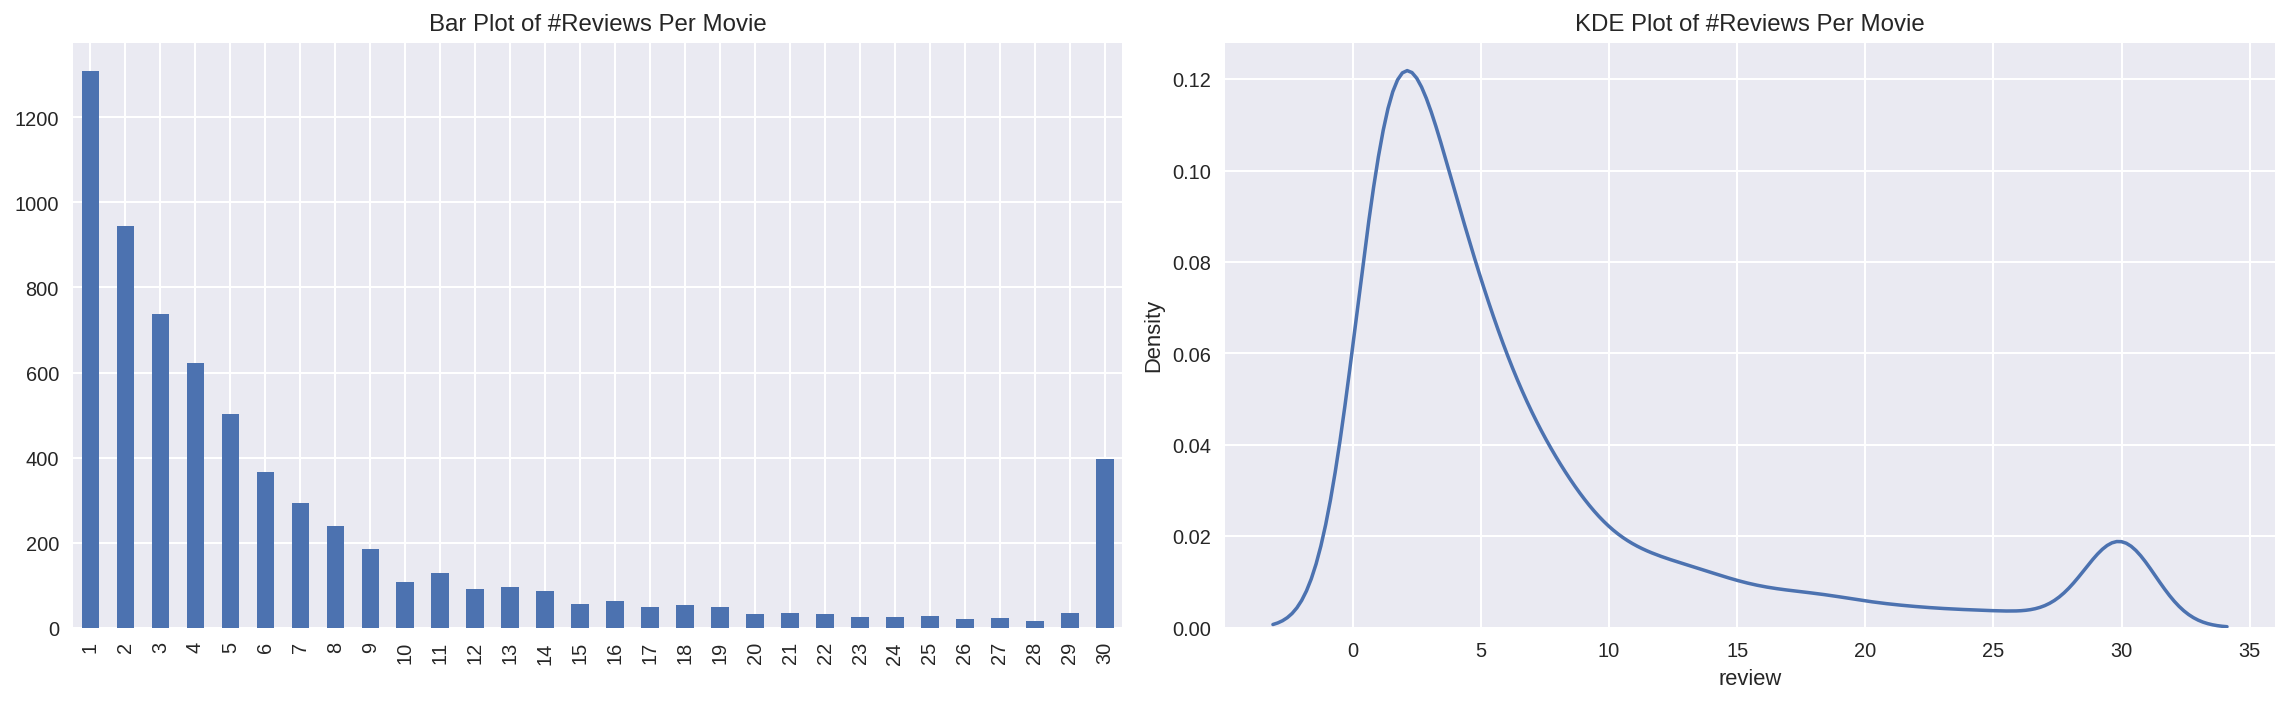

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Many movies only have a small number of reviews. The bast majority seem to only have between 1 and 10 reviews. There is an odd peak at exactly 30

In [10]:
df_reviews['pos'].value_counts()

0    23680
1    23561
Name: pos, dtype: int64

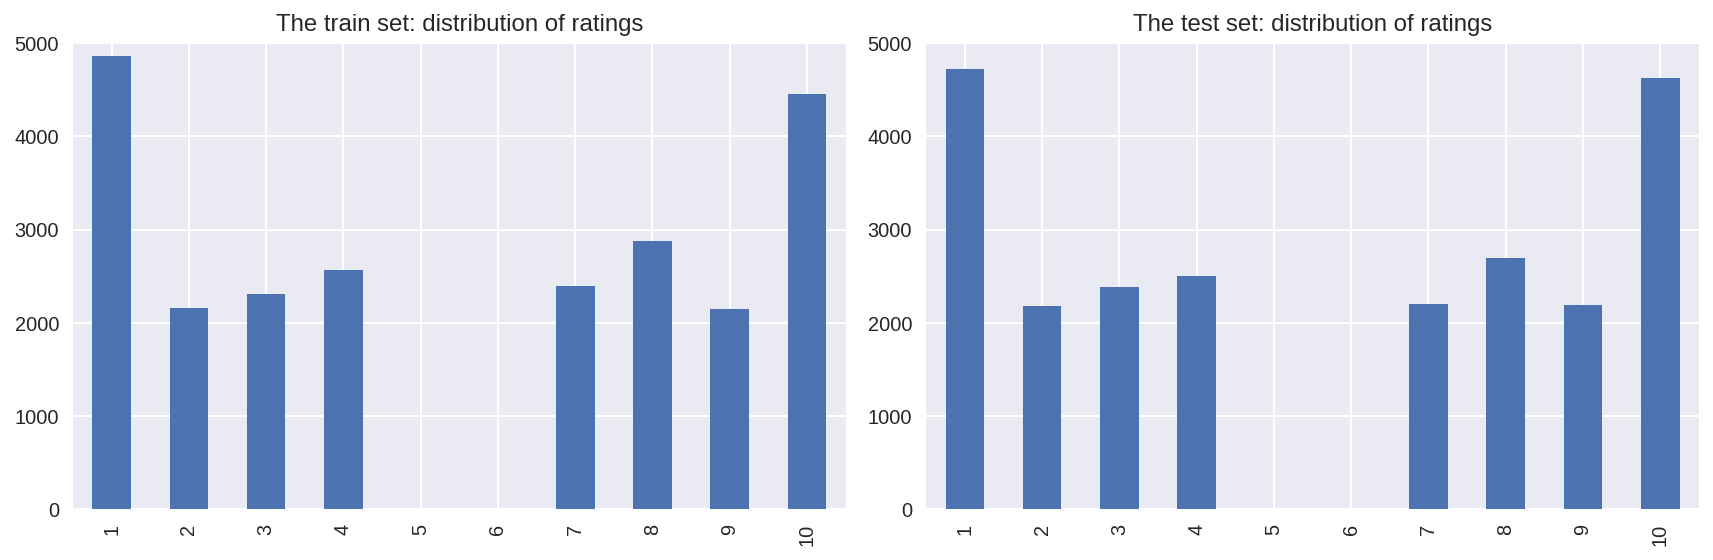

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

I see that my dataset is quite well balanced between negative and positive reviews. This bodes well for the incoming training. No class imbalance corrections are needed. 

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


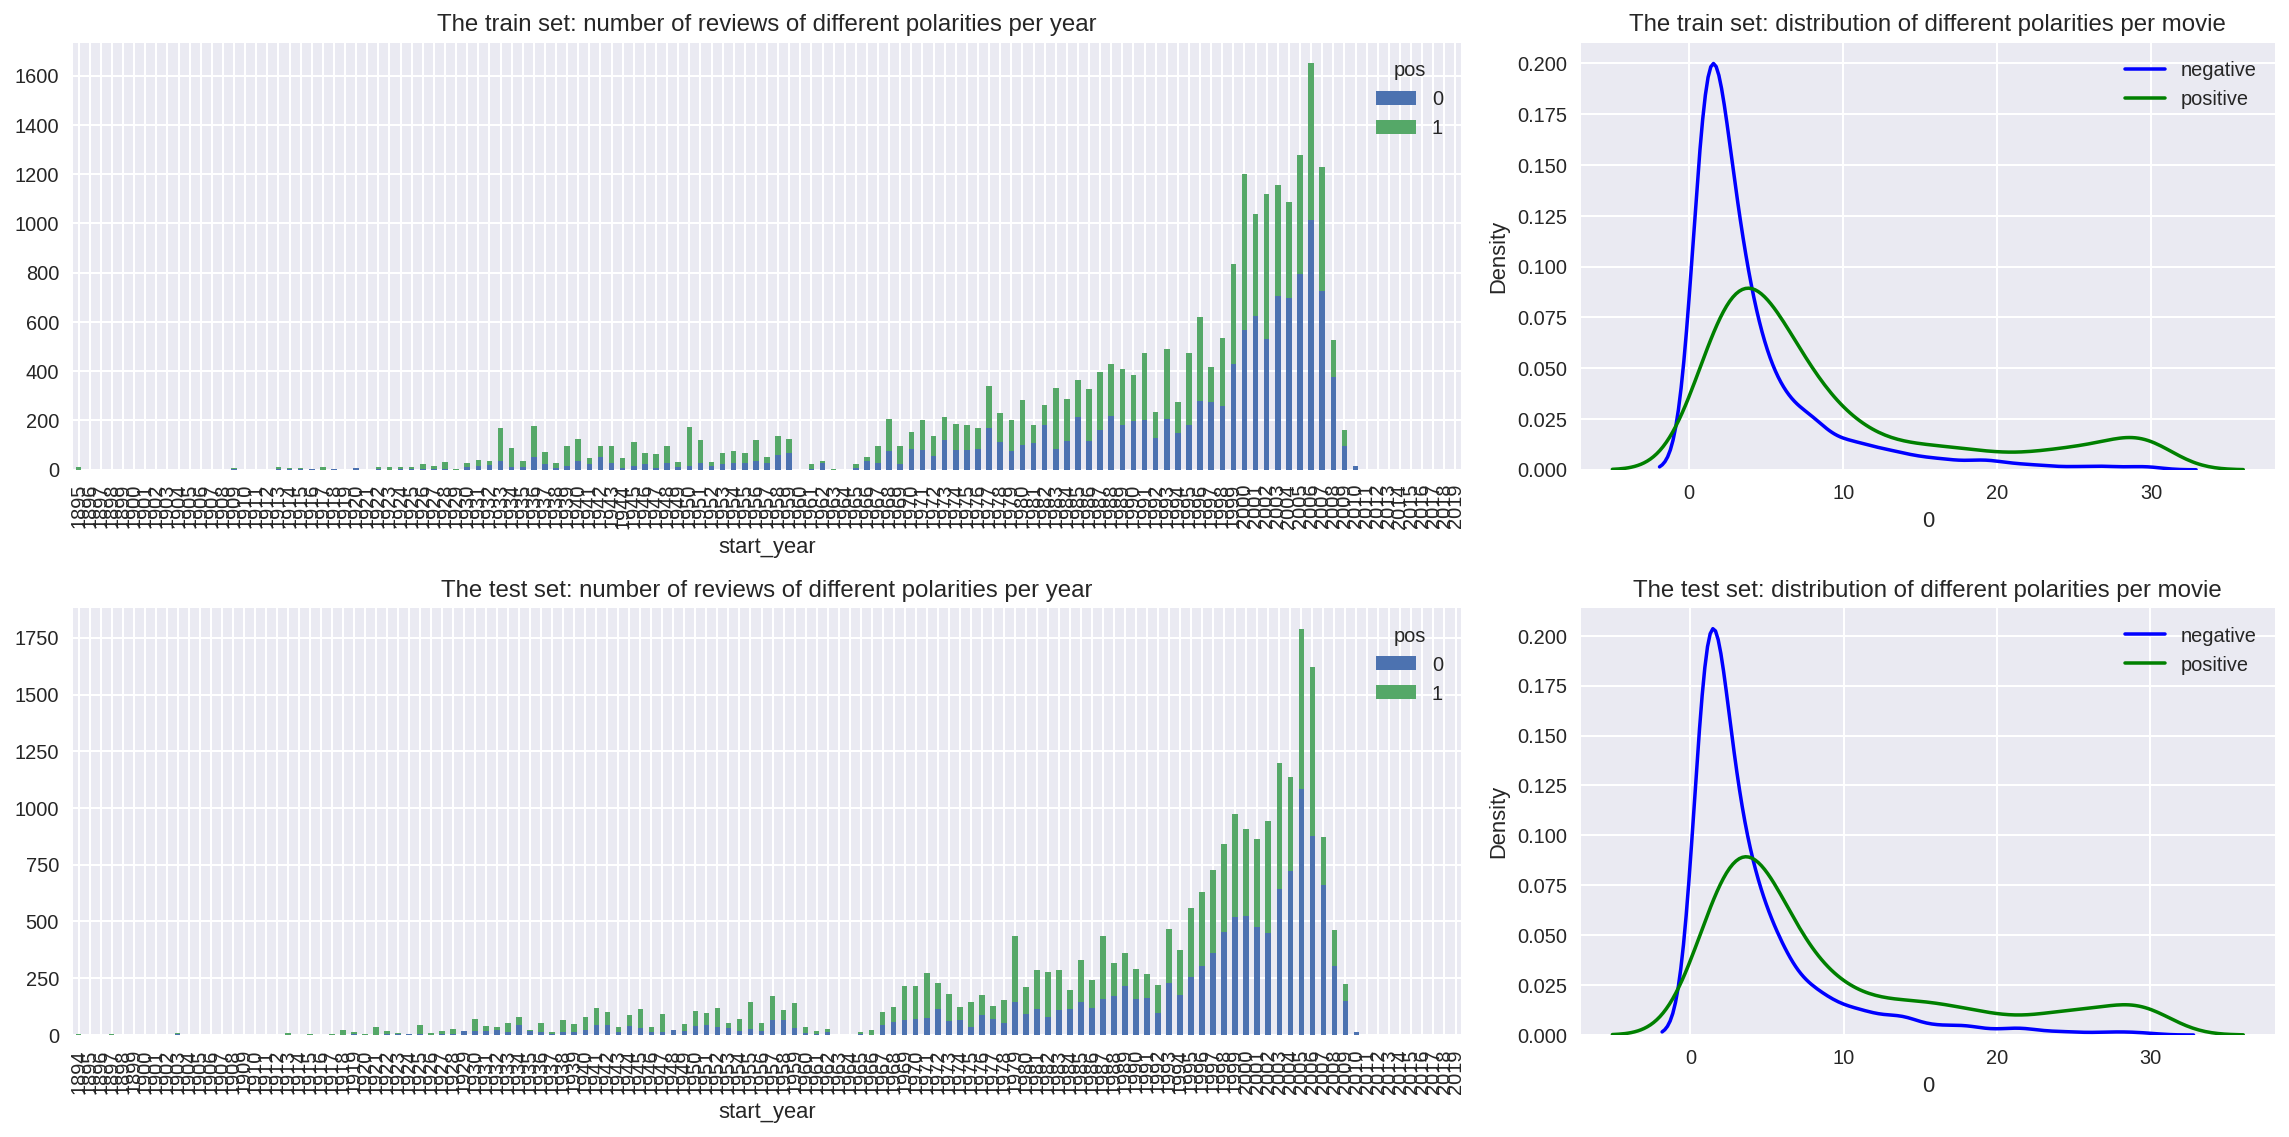

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Ovewr time, the number of both positive and negative reviews go up dramatically. The testing and training sets seem to have an almost identicle distribution. I will revisit this seeming class imbalance later if needed. The distribution of different polarities per movie seems to have a normal distribution for both negative and positive reviews with the negative reviews being more grouped up with a smaller standard deviation. This may mean that movies seen as more universally bad have more consistent bad reviews when compared to movies that are considered more universally neutral or good. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
def normalize_text(text):
    
    text = text.lower()
    
    text = text.translate(str.maketrans('', '', string.punctuation))
   
    text = text.translate(str.maketrans('', '', string.digits))
    return text


df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)


The revies have been normalized so that they can be used in all of the following models. 

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23758, 18)
(23483, 18)


## Working with models

### Model 0 - Constant

In [16]:
from sklearn.dummy import DummyClassifier

In [17]:
dummy = DummyClassifier(strategy='stratified', random_state=0)

In [18]:
dummy.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(random_state=0, strategy='stratified')

          train  test
Accuracy    0.5  0.50
F1          0.5  0.49
APS         0.5  0.50
ROC AUC     0.5  0.50


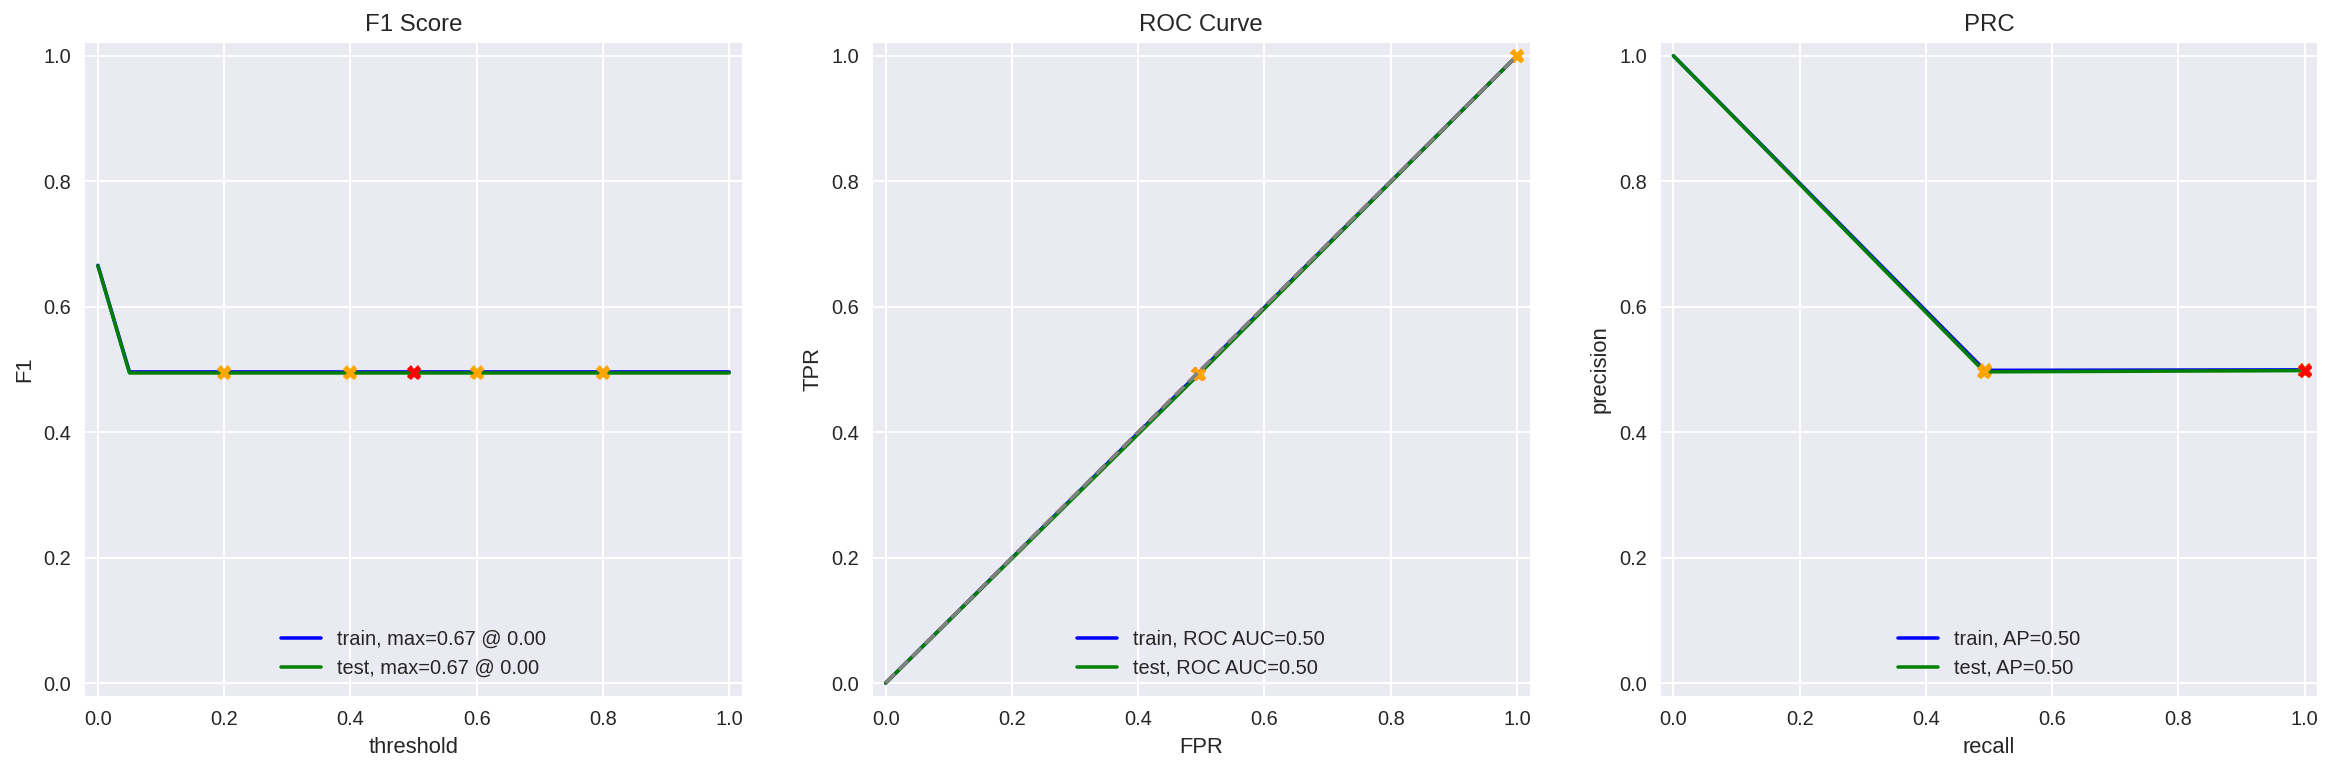

In [19]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']


evaluate_model(dummy, train_features, train_target, test_features, test_target)


The dummy model worked as expected. The stratified dummy strategy makes it so that the distribution of the data is the predicition output. This means that the model is performing at about chance level, making random predictions. Other models can now be compared to this model to show great improvements. 

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

NLTK for text processing, TF-IDF for feature extractions, Logistic Regression for model creation and target prediciton. 

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
def preprocess_text(text):
    
    text = text.lower()
    
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    
    translator = str.maketrans('', '', string.digits)
    text = text.translate(translator)
    
    
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    
    text = " ".join(words)
    
    return text


In [22]:
df_reviews_train['review_norm'] = df_reviews_train['review_norm'].apply(preprocess_text)
df_reviews_test['review_norm'] = df_reviews_test['review_norm'].apply(preprocess_text)

In [23]:
vectorizer = TfidfVectorizer()
train_features_1 = vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer.transform(df_reviews_test['review_norm'])


In [24]:
model_1 = LogisticRegression(solver='liblinear')
model_1.fit(train_features_1, train_target)


LogisticRegression(solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


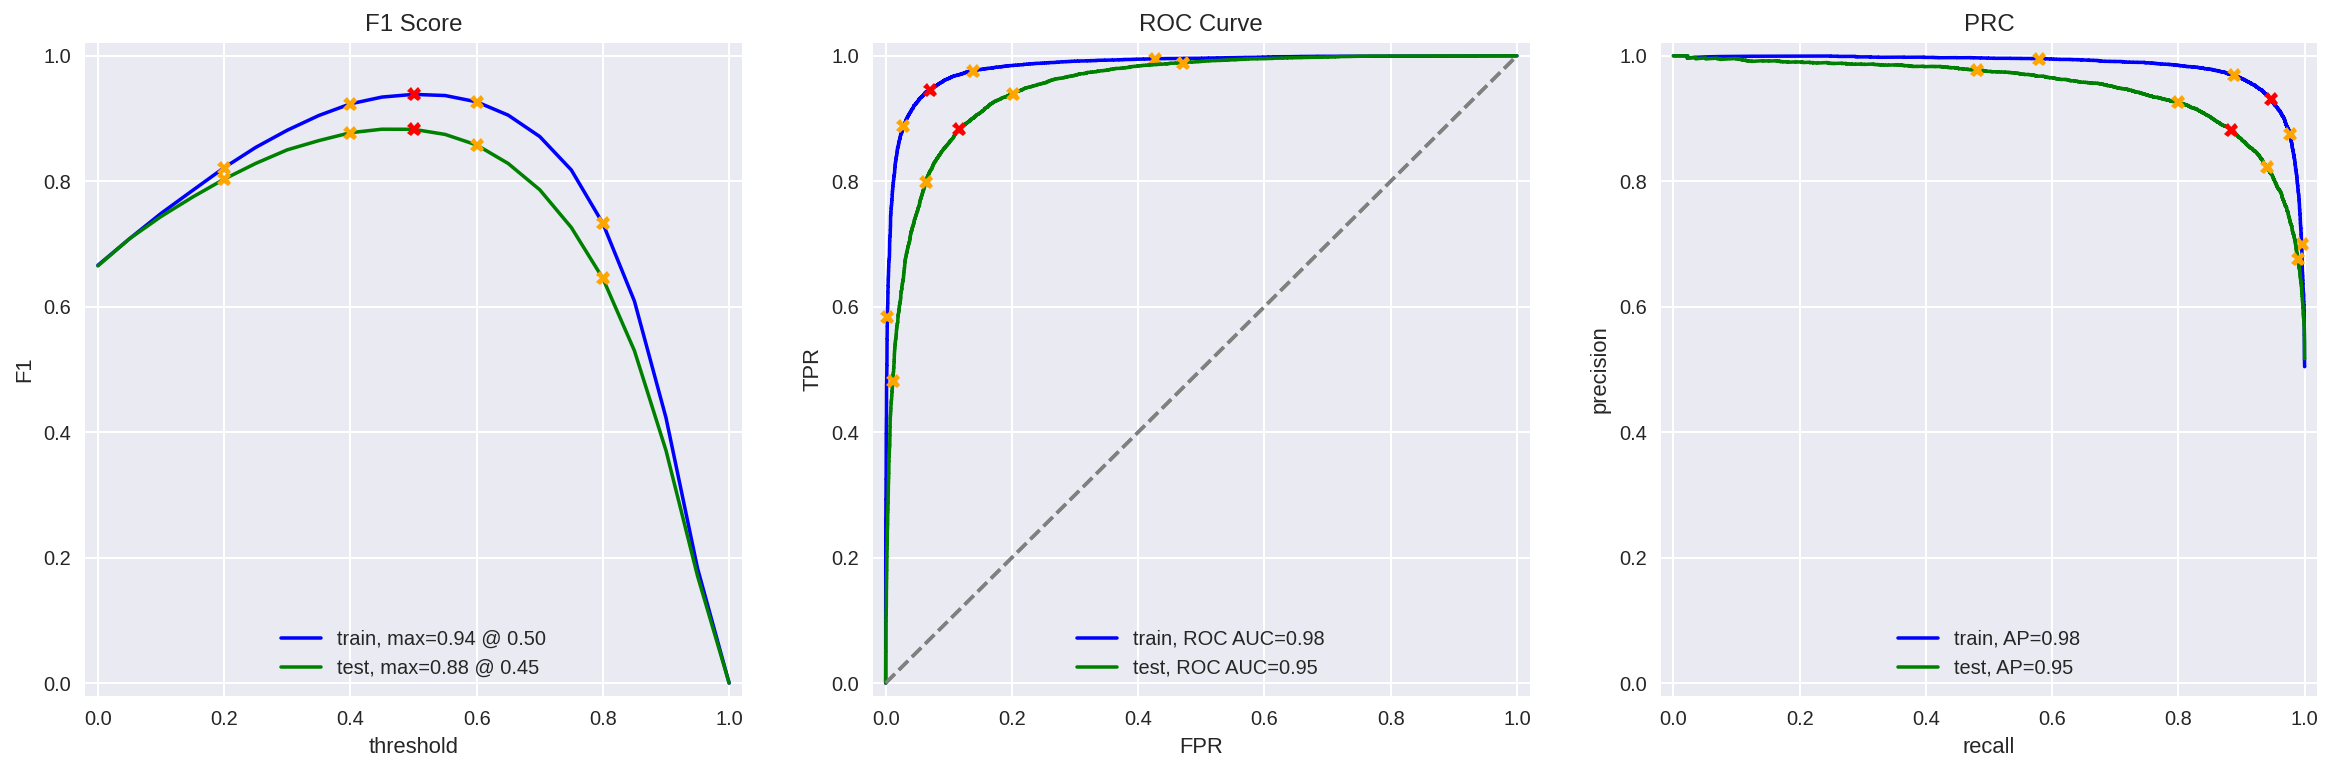

In [25]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

An F1 score of .88 on the testing set is excellent, although it is lower than the F1 score of the training set, that being .94. This trend holds for all of the results, Accuracy  dropping form  0.94  0.88, APS dropping from 0.98 to 0.95 and ROC AUC dropping form .98 to .95. It seems to me that this model is performing quite well at identifying positive reviews and negative reviews though. When compared to the dummy model, this is leaps and bounds better. 

### Model 3 - spaCy, TF-IDF and LR

SpaCy for text preprossing, TF-IDF for feature extraction, Logistic regression for model creation. 

In [26]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [28]:
df_reviews_train['review_norm'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)


In [29]:
vectorizer = TfidfVectorizer()
train_features_3 = vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_3 = vectorizer.transform(df_reviews_test['review_norm'])


In [30]:
model_3 = LogisticRegression(solver='liblinear')
model_3.fit(train_features_3, train_target)


LogisticRegression(solver='liblinear')

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


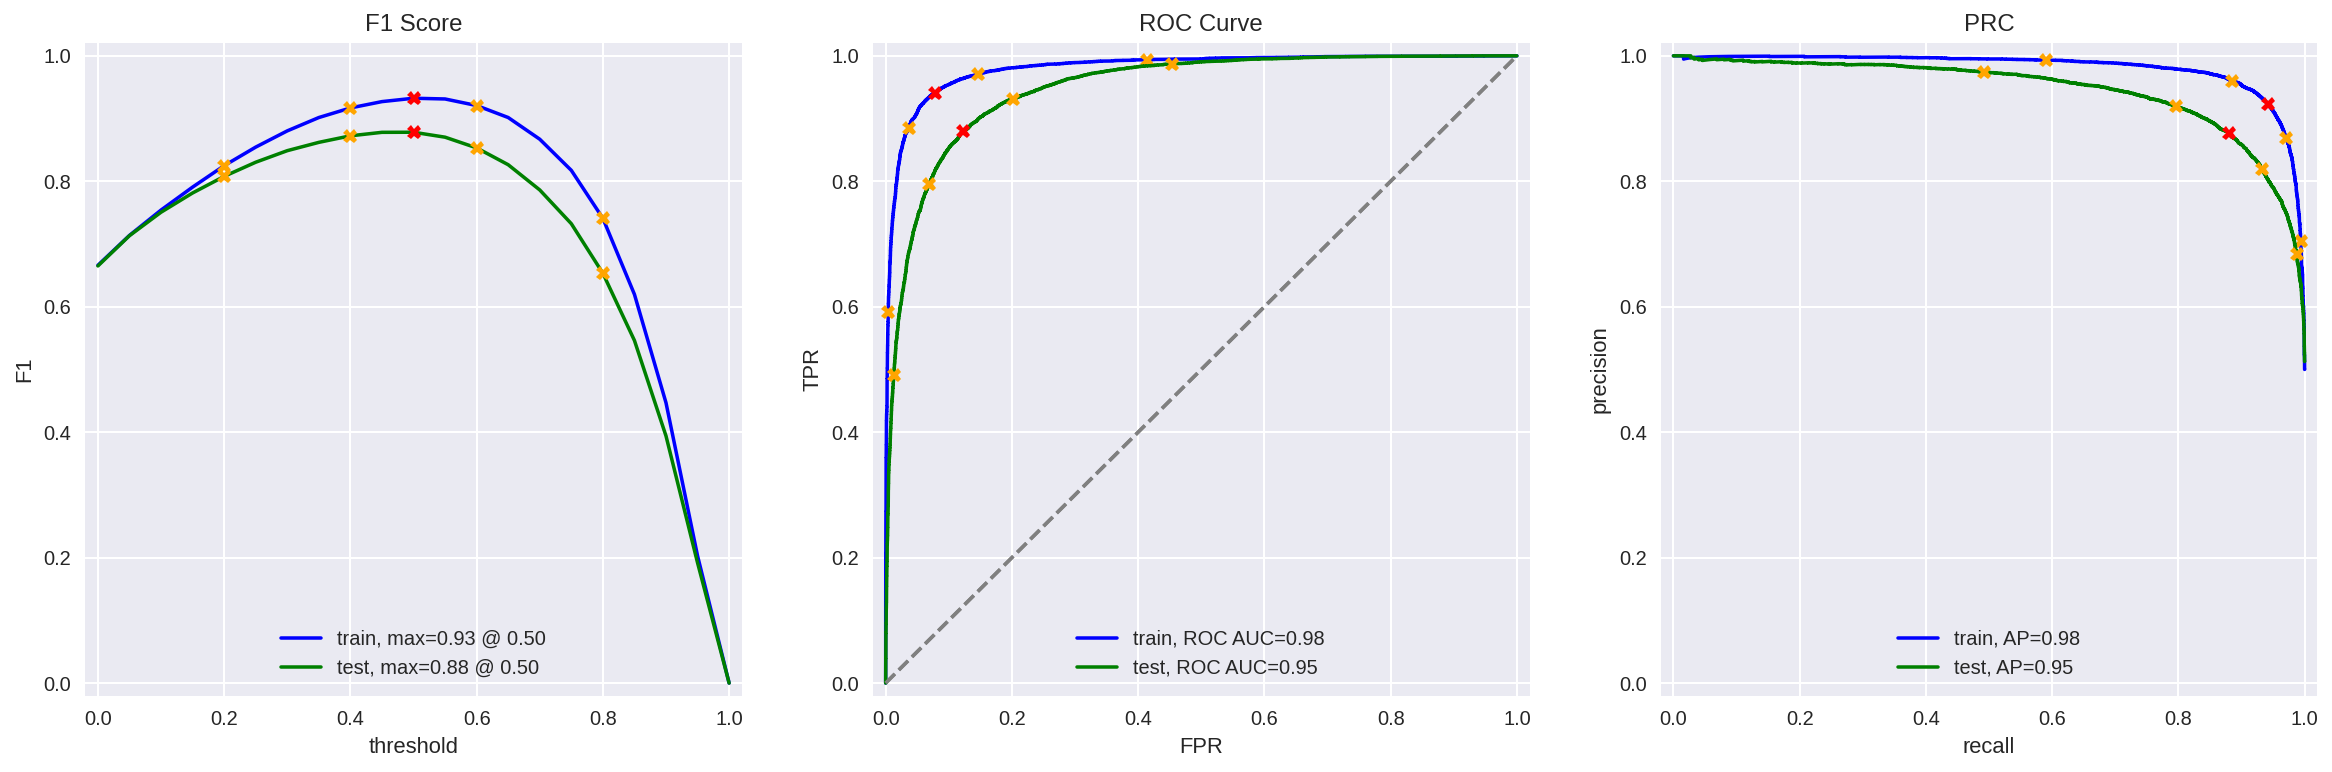

In [31]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)


Using spaCy instead of NLTK seems to have caused the vectorization to take much longer. It also outputed identicle test results to the previous model, which means these methods seem to be interchangable for this particular problem. Excellent results nontheless. 

### Model 4 - spaCy, TF-IDF and LGBMClassifier

SpaCy for text processing, TF-IDF for feature extraction and a gradient boosting model as the creating a model. 

In [32]:
from lightgbm import LGBMClassifier


In [33]:
vectorizer = vectorizer

train_features_4=train_features_3
test_features_4=test_features_3

In [36]:
model_4 = LGBMClassifier()
model_4.fit(train_features_4, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


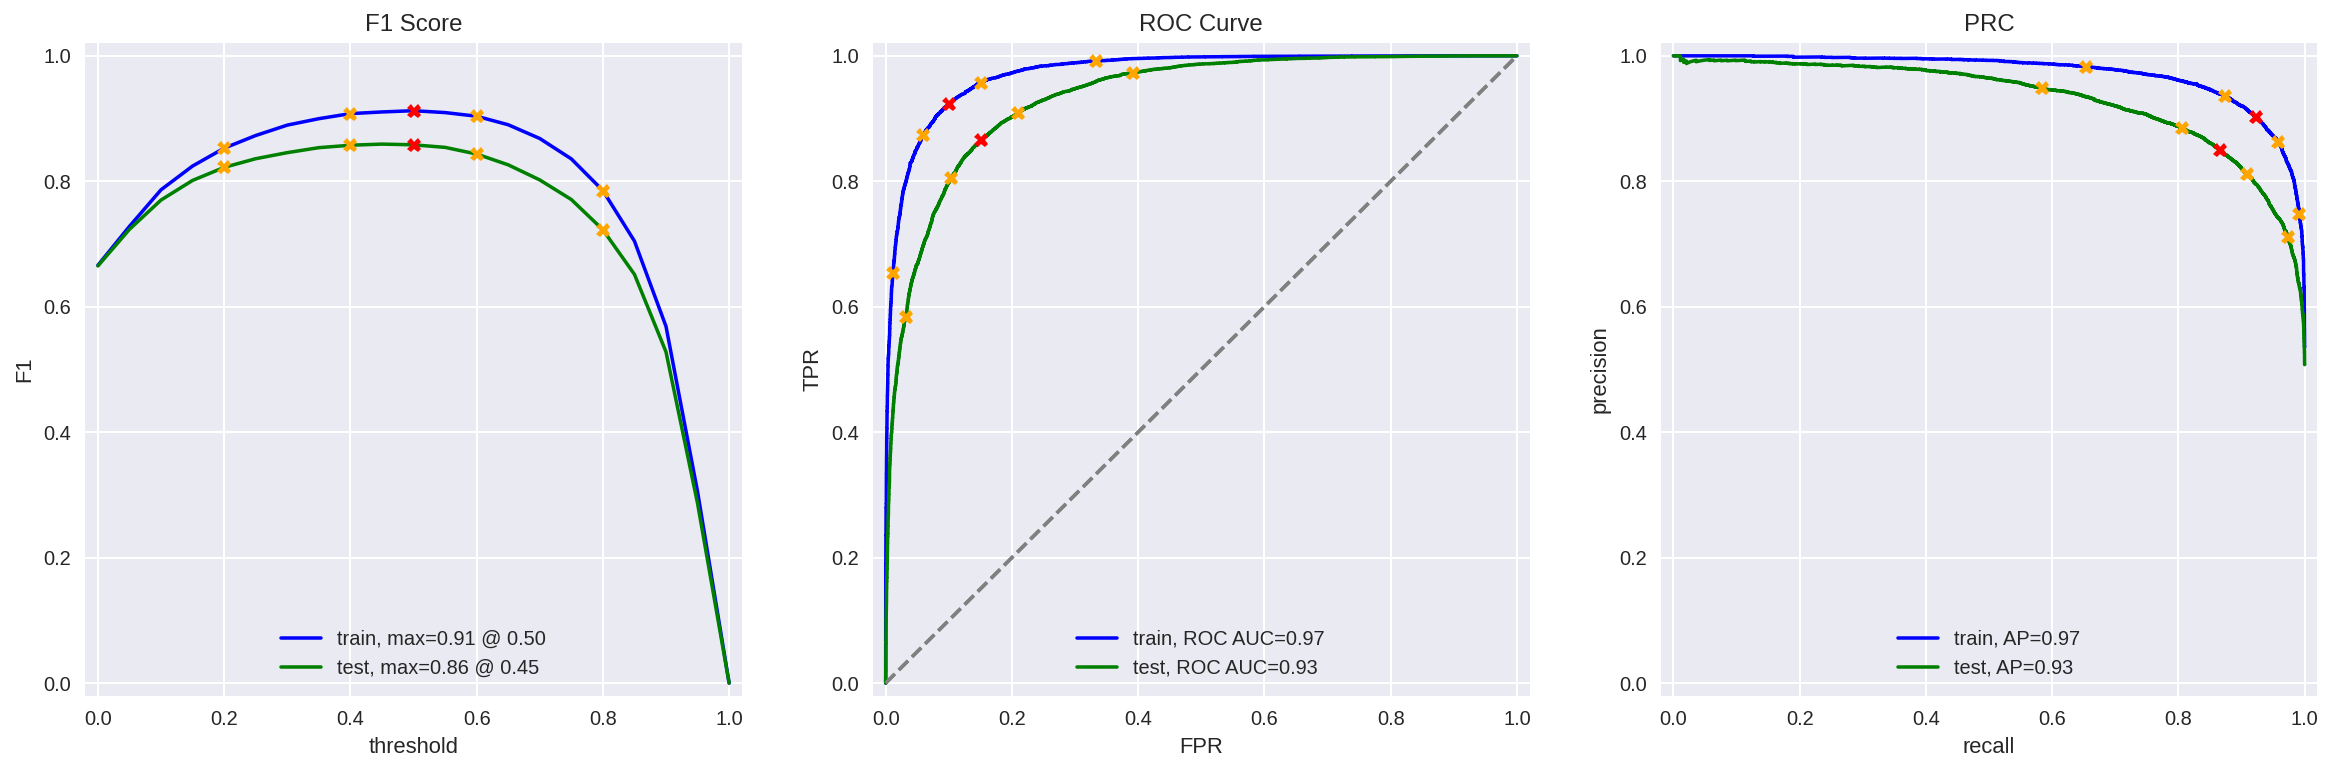

In [37]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)


Interestingly, the gradient boosting model as the classifier resulted in slightly worse test results, but test results that were still above the threshold F1 score of at lest 0.85. These results are still very good, indicated the model does a decent job at classifiying positive and negative reviews. Perhaps the model could be tuned in terms of hyperparameters, but this is not worth the trouble at the present time. 

###  Model 9 - BERT

Bidirectional Encoder Representations from Transformers for text processing and feature extraction. I did try very hard to use this method for text processing and feature extraction, however I did not see it run without crashing the kernal. I will not be using or evaluating this model, but I did create what I think would have been a functional model. 

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            truncation=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(encoding['input_ids'])
        attention_mask_list.append(encoding['attention_mask'])

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.cat(ids_list[batch_size*i:batch_size*(i+1)], dim=0).to(device)
        attention_mask_batch = torch.cat(attention_mask_list[batch_size*i:batch_size*(i+1)], dim=0).to(device)
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)



In [ ]:
df_reviews_train = df_reviews_train[:100]
df_reviews_test = df_reviews_test[:100]

In [ ]:
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

In [ ]:
train_embeddings = BERT_text_to_embeddings(df_reviews_train['review_norm'].tolist())
test_embeddings = BERT_text_to_embeddings(df_reviews_test['review_norm'].tolist())

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_embeddings, train_target)


In [ ]:
evaluate_model(model, train_embeddings, train_target, test_embeddings, test_target)

## My Reviews

In [60]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])


my_reviews['review_norm'] = my_reviews['review'].apply(preprocess_text)


texts = my_reviews['review_norm']


texts_transformed = vectorizer.transform(texts)


### Model 1

In [61]:
vectorizer = TfidfVectorizer()
train_features_1 = vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer.transform(df_reviews_test['review_norm'])


model_1 = LogisticRegression(solver='liblinear')
model_1.fit(train_features_1, train_target)
my_reviews_pred_prob = model_1.predict_proba(texts_transformed)[:, 1]


for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.23:  simply like kind movie
0.23:  well bored felt asleep middle movie
0.58:  really fascinated movie
0.31:  even actors looked really old disinterested got paid movie soulless cash grab
0.44:  didnt expect reboot good writers really cared source material
0.49:  movie upsides downsides feel like overall decent flick could see going see
0.09:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.94:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 3

In [62]:
my_reviews_pred_prob = model_3.predict_proba(texts_transformed)[:, 1]


for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.23:  simply like kind movie
0.23:  well bored felt asleep middle movie
0.58:  really fascinated movie
0.31:  even actors looked really old disinterested got paid movie soulless cash grab
0.44:  didnt expect reboot good writers really cared source material
0.49:  movie upsides downsides feel like overall decent flick could see going see
0.09:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.94:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 4

In [64]:
my_reviews_pred_prob = model_4.predict_proba(texts_transformed)[:, 1]


for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  simply like kind movie
0.46:  well bored felt asleep middle movie
0.62:  really fascinated movie
0.51:  even actors looked really old disinterested got paid movie soulless cash grab
0.75:  didnt expect reboot good writers really cared source material
0.68:  movie upsides downsides feel like overall decent flick could see going see
0.34:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.78:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


## Conclusions

In conclusion, using logistic regression models for this task was more effective than using gradient boosting. Both types worked well on the test set, and both types of models were able to be applied to my own reviews above. They seem to behave differently, with different probablilities asigned across the 7 examples, but if it was a classification task of being above or below .5, the models in my view were still able to classify negative vs postive sentiment. The varying strength of the probablilites seems to not make a major difference. I was not able to create a working BERT model unfortunately, but it was not necessary. 